# topographic correlation analyses for full resting state recordings

This notebook computes the correlation coefficient ($r$) between slope and age for all channels. These vectors will be used with EEGLAB's `topoplot` function to construct a topographic visualization of correlations. 

**Possibilities - Compute topographic corr maps for:**
    - Voytek groups
    - All groups
    - Younger adults, including older folks
    - MCI Controls

In [2]:
import os
import glob
import datetime

import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
import scipy.io
import numpy.fft
import scipy.signal
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn import linear_model

%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)

In [3]:
df = pd.read_csv('../work/2016-08-19-14:30:32.303371/ya-oa-full-ransac-2-24-eyesc-eyeso.csv')

In [3]:
df.head()

,SUBJECT,CLASS,AGE,SEX,AVG_OA_PSD_EYESC,AVG_OA_PSD_EYESO,AVG_YA_PSD_EYESC,AVG_YA_PSD_EYESO,AVG_PSD_EYESC,AVG_PSD_EYESO,...,B26_EYESO,B27_EYESO,B28_EYESO,B29_EYESO,B30_EYESO,FRONTAL_EYESO,LTEMPORAL_EYESO,CENTRAL_EYESO,RTEMPORAL_EYESO,OCCIPITAL_EYESO
0,120127101,SA_Control,80.84873,2.0,-2.796664,-2.125381,-5.096711,-4.123996,-6.159212,-5.311616,...,-6.837667,-8.136131,-8.911845,-7.736430,-5.724752,-7.499692,-9.870920,-9.256354,-8.718649,-7.131687
1,120127102,MCI_Control,71.89870,1.0,-2.796664,-2.125381,-5.096711,-4.123996,-4.186760,-0.868985,...,-0.520633,-3.601172,-6.186407,-2.876996,-0.603407,-1.895668,-1.071544,-5.032359,-1.261886,-1.694917
2,120127103,MCI_Control,69.43463,2.0,-2.796664,-2.125381,-5.096711,-4.123996,-3.415864,0.909542,...,-1.753993,-5.878322,-6.263851,-7.060527,-3.114273,-4.229089,-5.551192,-6.417229,-5.150955,-2.743728
3,120127104,SA_Control,83.61396,2.0,-2.796664,-2.125381,-5.096711,-4.123996,-3.275827,-1.230587,...,-6.109233,-5.419716,-5.129504,-4.446472,-6.475038,-4.464693,-5.451922,-4.256616,-2.160842,-4.840057
4,120127105,SA_Control,80.69541,2.0,-2.796664,-2.125381,-5.096711,-4.123996,-4.252674,-4.532732,...,-4.676017,-3.850005,-6.106927,-6.967415,-7.035794,-6.304408,-5.077599,-5.899741,-5.250663,-8.530632


In [7]:
ch_eyesc = list(df.columns.values)[10:63]
ch_eyeso = list(df.columns.values)[68:121]
print(len(ch_eyesc))
print(len(ch_eyeso))

53
53


## Voytek groups

In [15]:
oa_voytek = df[df.AGE >= 60]
oa_voytek = oa_voytek[oa_voytek.CLASS != 'SA']
ya_voytek = df[df.AGE <= 35.5]
voytek = pd.concat([oa_voytek, ya_voytek])
voytek.head()

,SUBJECT,CLASS,AGE,SEX,AVG_OA_PSD_EYESC,AVG_OA_PSD_EYESO,AVG_YA_PSD_EYESC,AVG_YA_PSD_EYESO,AVG_PSD_EYESC,AVG_PSD_EYESO,...,B26_EYESO,B27_EYESO,B28_EYESO,B29_EYESO,B30_EYESO,FRONTAL_EYESO,LTEMPORAL_EYESO,CENTRAL_EYESO,RTEMPORAL_EYESO,OCCIPITAL_EYESO
0,120127101,SA_Control,80.84873,2.0,-2.796664,-2.125381,-5.096711,-4.123996,-6.159212,-5.311616,...,-6.837667,-8.136131,-8.911845,-7.736430,-5.724752,-7.499692,-9.870920,-9.256354,-8.718649,-7.131687
1,120127102,MCI_Control,71.89870,1.0,-2.796664,-2.125381,-5.096711,-4.123996,-4.186760,-0.868985,...,-0.520633,-3.601172,-6.186407,-2.876996,-0.603407,-1.895668,-1.071544,-5.032359,-1.261886,-1.694917
2,120127103,MCI_Control,69.43463,2.0,-2.796664,-2.125381,-5.096711,-4.123996,-3.415864,0.909542,...,-1.753993,-5.878322,-6.263851,-7.060527,-3.114273,-4.229089,-5.551192,-6.417229,-5.150955,-2.743728
3,120127104,SA_Control,83.61396,2.0,-2.796664,-2.125381,-5.096711,-4.123996,-3.275827,-1.230587,...,-6.109233,-5.419716,-5.129504,-4.446472,-6.475038,-4.464693,-5.451922,-4.256616,-2.160842,-4.840057
4,120127105,SA_Control,80.69541,2.0,-2.796664,-2.125381,-5.096711,-4.123996,-4.252674,-4.532732,...,-4.676017,-3.850005,-6.106927,-6.967415,-7.035794,-6.304408,-5.077599,-5.899741,-5.250663,-8.530632


In [16]:
r_values_eyesc = []
for ch in ch_eyesc:
    r_values_eyesc.append(np.corrcoef(voytek.AGE, voytek[ch])[0][1])
r_values_eyeso = []
for ch in ch_eyeso:
    r_values_eyeso.append(np.corrcoef(voytek.AGE, voytek[ch])[0][1])

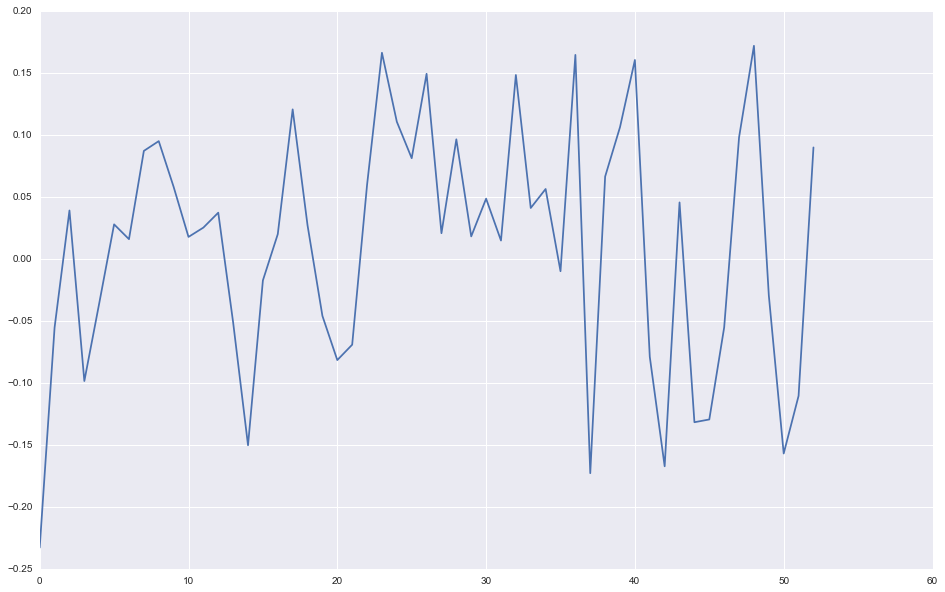

In [17]:
plt.plot(r_values_eyesc)

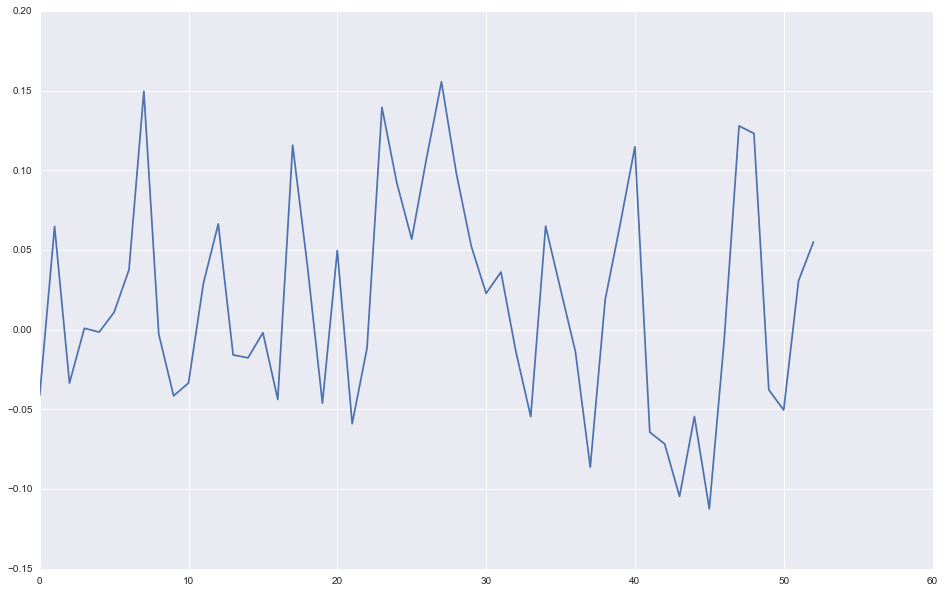

In [18]:
plt.plot(r_values_eyeso)

In [66]:
r_values_eyesc

[-0.14527812704101595,
 -0.040690310855963349,
 0.11107160407216499,
 -0.062226475769467701,
 0.016037765981046084,
 0.015204556016161008,
 0.039269914191121365,
 0.098274539343608261,
 0.1920502546955081,
 0.13593692836991556,
 0.059347022946537389,
 0.072730914957255782,
 0.046180444758687794,
 0.0025480243045337154,
 -0.075625490793488834,
 0.046990919722307359,
 0.1324439645790618,
 0.20083267759485041,
 0.075487793485801397,
 -0.028290972412803171,
 -0.069627735699371432,
 -0.00031614110929892222,
 0.082059990142133818,
 0.23151075205836055,
 0.14922092018237204,
 0.12788575579454689,
 0.20555083061529825,
 0.087852381695460321,
 0.15744693715359331,
 0.044778137105181935,
 0.097813834270481043,
 0.090294009003477241,
 0.16928404189902724,
 0.14232913269397002,
 0.14487328170055713,
 0.1365554411224619,
 0.18639407191390014,
 -0.015037431561675944,
 0.1773477608325095,
 0.18714938610757539,
 0.27181717232438085,
 0.015955008676341146,
 -0.096577681983400304,
 0.050487200988756475,

In [67]:
r_values_eyeso

[0.080575033496249865,
 0.15247637427928432,
 0.067878862280933761,
 0.067086123959091276,
 0.096734694023915213,
 0.02758497864284095,
 0.078028374821868848,
 0.20084306749868919,
 0.093880569657426569,
 0.029642992610836531,
 0.079358465551890356,
 0.09686607895460117,
 0.034175510042644054,
 0.066260214664767517,
 0.078470846092334914,
 0.14008182421543841,
 0.033263976153907165,
 0.23588310278228314,
 0.11164415240521525,
 0.0095382513593591581,
 0.11273183602931662,
 0.05394544615795021,
 0.077308996097729968,
 0.25268116282540104,
 0.17364694998469918,
 0.18633695865138211,
 0.18472912754704648,
 0.26067283608534453,
 0.2080096203416765,
 0.17112172226974359,
 0.06904520557936146,
 0.18063449984771224,
 0.131326430726599,
 0.0789515635719715,
 0.19478137381018984,
 0.089116383122966977,
 0.014322609846426524,
 -0.011098598598647074,
 0.098267168027514451,
 0.15675209144542687,
 0.21729157220877063,
 0.033982801161226386,
 -0.013200332751271544,
 0.020783483666829201,
 -0.00695506

## Dane dataset

In [21]:
dane = df[df.CLASS.isin(['DANE'])]
dane.head()

,SUBJECT,CLASS,AGE,SEX,AVG_OA_PSD_EYESC,AVG_OA_PSD_EYESO,AVG_YA_PSD_EYESC,AVG_YA_PSD_EYESO,AVG_PSD_EYESC,AVG_PSD_EYESO,...,B26_EYESO,B27_EYESO,B28_EYESO,B29_EYESO,B30_EYESO,FRONTAL_EYESO,LTEMPORAL_EYESO,CENTRAL_EYESO,RTEMPORAL_EYESO,OCCIPITAL_EYESO
54,1121181181,DANE,29.0,2.0,-2.796664,-2.125381,-5.096711,-4.123996,0.036697,-4.927723,...,-5.642869,-7.722677,-5.875141,-5.516647,-5.270341,-5.593504,-7.031172,-7.039792,-6.488637,-6.403605
55,1121181183,DANE,25.0,2.0,-2.796664,-2.125381,-5.096711,-4.123996,-2.318055,-2.763745,...,-5.092277,-3.987819,-5.287109,-5.530812,-3.950173,-3.974978,-4.805786,-4.752302,-5.986426,-5.643811
56,1121181218,DANE,31.0,1.0,-2.796664,-2.125381,-5.096711,-4.123996,-4.646537,-3.096614,...,-4.670298,-6.201320,-6.453043,-6.164918,-3.325963,-5.018789,-4.587235,-6.254777,-5.513969,-5.619165
57,1121181262,DANE,25.0,2.0,-2.796664,-2.125381,-5.096711,-4.123996,-2.372888,-1.838394,...,-1.845163,-3.532838,-6.903063,-7.087583,-1.473361,-5.976520,-3.354223,-4.314426,-4.780336,-4.873669
58,1121181286,DANE,35.0,2.0,-2.796664,-2.125381,-5.096711,-4.123996,-4.918578,-2.906315,...,-6.531669,-6.780360,-7.655775,-6.708645,-7.515896,-3.052747,-2.325238,-2.970536,-5.950346,-7.759312


In [22]:
r_values_eyesc = []
for ch in ch_eyesc:
    r_values_eyesc.append(np.corrcoef(dane.AGE, dane[ch])[0][1])
r_values_eyeso = []
for ch in ch_eyeso:
    r_values_eyeso.append(np.corrcoef(dane.AGE, dane[ch])[0][1])

In [23]:
r_values_eyesc

[-0.10907434927594636,
 -0.15686350354662773,
 -0.00099248388337564862,
 0.12624002351097624,
 -0.052126529572557485,
 0.21142902500354976,
 0.15679918160992051,
 0.13562075304080637,
 0.14414945555587963,
 -0.095107505719870339,
 0.054771391410145247,
 -0.036001148154093499,
 -0.12893086207360102,
 -0.058492146376632373,
 -0.14133282178106854,
 0.026523122421020395,
 0.052996605042825592,
 0.058424230207690296,
 0.14630293358725166,
 0.17660762549069065,
 -0.14893120619582617,
 0.19853243906022672,
 0.23180225290128451,
 0.19354743047043191,
 0.07592002832523384,
 0.20139300487740677,
 0.15283088748334556,
 -0.17022402899278108,
 -0.058198602438874411,
 0.11424120087563756,
 0.23994467529857333,
 0.091273202849494972,
 0.017445202749353555,
 0.052236591054900153,
 0.012639114786721565,
 0.005810906550956123,
 -0.011420646393592528,
 0.19901979837457962,
 0.072244585983964063,
 0.054096155718886749,
 0.022657599035543693,
 0.022426746190273742,
 0.079729440508654242,
 0.055641400039249

In [24]:
r_values_eyeso

[-0.056692882750263025,
 0.090542246180012206,
 0.11215518911277847,
 0.1535019071083136,
 0.1020497935810189,
 0.27677849943185706,
 0.27903101004569952,
 0.18696216343966579,
 -0.0068049573771491872,
 0.052247072571471001,
 0.10952757584761273,
 0.31759029592518545,
 0.2423492412200712,
 -0.05196575327596465,
 -0.20909494596816794,
 -0.16309278459091817,
 -0.16585992018237708,
 0.15553008335860949,
 0.072782317899234714,
 0.11268122147825148,
 0.0083766424427623963,
 0.17369889635307584,
 0.29098210685993259,
 0.10991648045538735,
 0.12699046895291741,
 0.18879261582768589,
 0.17611795302836053,
 -0.090131941419070549,
 -0.019086689327632099,
 0.22009408012659928,
 0.35441476393023535,
 -0.0092824188078930951,
 -0.022720192657484414,
 0.19924758678093443,
 0.053865397315613399,
 0.04351400874929065,
 0.12110424451182925,
 0.031922218090853695,
 -0.032427497333534047,
 -0.0027914450220964172,
 0.088438770855524873,
 0.093830309535500922,
 0.077705011308426497,
 0.12982139006431326,
 -

## Dane and MCI Controls

In [5]:
dane_mci = df[df.CLASS.isin(['MCI_Control', 'DANE'])]
dane_mci.head()

,SUBJECT,CLASS,AGE,SEX,AVG_OA_PSD_EYESC,AVG_OA_PSD_EYESO,AVG_YA_PSD_EYESC,AVG_YA_PSD_EYESO,AVG_PSD_EYESC,AVG_PSD_EYESO,...,B26_EYESO,B27_EYESO,B28_EYESO,B29_EYESO,B30_EYESO,FRONTAL_EYESO,LTEMPORAL_EYESO,CENTRAL_EYESO,RTEMPORAL_EYESO,OCCIPITAL_EYESO
1,120127102,MCI_Control,71.89870,1.0,-2.796664,-2.125381,-5.096711,-4.123996,-4.186760,-0.868985,...,-0.520633,-3.601172,-6.186407,-2.876996,-0.603407,-1.895668,-1.071544,-5.032359,-1.261886,-1.694917
2,120127103,MCI_Control,69.43463,2.0,-2.796664,-2.125381,-5.096711,-4.123996,-3.415864,0.909542,...,-1.753993,-5.878322,-6.263851,-7.060527,-3.114273,-4.229089,-5.551192,-6.417229,-5.150955,-2.743728
5,120127106,MCI_Control,77.41547,2.0,-2.796664,-2.125381,-5.096711,-4.123996,-3.865297,0.620052,...,-0.403983,-2.002179,-4.835986,-2.702375,-0.773936,0.200628,-1.480091,-0.884714,-1.572574,-1.544021
10,120127111,MCI_Control,77.72211,2.0,-2.796664,-2.125381,-5.096711,-4.123996,-4.334330,-4.202070,...,-5.452952,-6.547568,-6.774276,-6.361649,-5.842541,-5.900474,-6.168116,-6.077073,-5.751652,-5.979365
11,120127112,MCI_Control,73.25941,2.0,-2.796664,-2.125381,-5.096711,-4.123996,-3.735324,-0.578287,...,-6.676929,-6.320994,-6.103412,-6.220323,-6.320729,-3.470014,-6.043049,-2.145268,-6.770210,-5.943052


In [8]:
r_values_eyesc = []
for ch in ch_eyesc:
    r_values_eyesc.append(np.corrcoef(dane_mci.AGE, dane_mci[ch])[0][1])
r_values_eyeso = []
for ch in ch_eyeso:
    r_values_eyeso.append(np.corrcoef(dane_mci.AGE, dane_mci[ch])[0][1])

In [9]:
r_values_eyesc

[-0.17514096359253456,
 0.053172223886701397,
 0.18391945220141151,
 0.032586433453550785,
 -0.031927821026527491,
 0.10107580663322396,
 -0.00084892203192440485,
 0.20133398812573999,
 0.21174734453343025,
 0.045560728127133458,
 0.13839359122181991,
 0.06975536107704218,
 0.071717311183339114,
 6.0784063537074025e-05,
 -0.012212870422416953,
 0.060988303334420346,
 0.050599723954327172,
 0.25541367779024965,
 0.18198537906547149,
 0.065808841227009668,
 -0.05014774673318851,
 -0.031290926008927918,
 0.19872391068570466,
 0.23570166321121172,
 0.31423328382687199,
 0.23707708219106408,
 0.33161646200546663,
 0.03628135352337615,
 0.10008541434643871,
 0.043513635595962295,
 0.13694767604300359,
 -0.033470094257898264,
 0.20294167320048026,
 0.035776573093613616,
 0.001625949014514963,
 0.1349880581272373,
 0.19106346628008222,
 -0.15135578839613578,
 0.04912883181075451,
 0.16619445087779339,
 0.27578905161568845,
 0.047953052490515256,
 -0.16248146863943952,
 0.1048997803119131,
 -0.

In [10]:
r_values_eyeso

[0.085050126012006816,
 0.2156849257598728,
 0.024669310376011385,
 0.14275546331195665,
 0.15002327578157518,
 0.15907332952272896,
 0.14498776657373239,
 0.2496000787012744,
 0.16657347470650383,
 0.079644703854717461,
 0.21420558470185028,
 0.076211223250528287,
 0.15484808613781106,
 0.049996621794935851,
 0.12779788796474922,
 0.11425961736816914,
 0.037001599276958209,
 0.24299888776528766,
 0.24587904357060408,
 0.11161280878451349,
 0.12055932300519227,
 0.093302819562543257,
 0.1993979721243061,
 0.26281579051500409,
 0.34938362505988507,
 0.28118092859683608,
 0.28669639838335464,
 0.1543483441983754,
 0.10664135362291005,
 0.18674551987597995,
 0.14753794054340272,
 0.17652133516945184,
 0.10040359579787718,
 0.058187067768495762,
 0.12512152924262976,
 0.13062889060370889,
 0.092423654320775706,
 -0.042296820241430229,
 0.068748324281645248,
 0.076228954290260428,
 0.20466919921727431,
 0.10696193465127148,
 0.038879210750061129,
 -0.014493942143901943,
 0.02983815330145682